# Question 1: Who are the elderly residents in Allston-Brighton, and where are they located?

This notebook analyzes elderly residents (62+) from the Allston-Brighton voter dataset and their geographic distribution.


In [ ]:
import sys
import os

current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_dir = os.path.dirname(current_dir)
else:
    parts = current_dir.split(os.sep)
    if 'fa25-team-a' in parts:
        idx = parts.index('fa25-team-a')
        project_dir = os.sep.join(parts[:idx+1])
    else:
        project_dir = os.path.dirname(os.path.dirname(current_dir))
web_app_path = os.path.join(project_dir, 'web_app')
sys.path.append(web_app_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import folium
from folium import plugins
from config.database import get_db_connection, execute_query

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Elderly Resident Count from Allston-Brighton Voter Dataset


In [2]:
query = """
SELECT 
    COUNT(*) as total_voters,
    COUNT(*) FILTER (WHERE is_elderly = true) as elderly_count,
    ROUND(COUNT(*) FILTER (WHERE is_elderly = true) * 100.0 / COUNT(*), 2) as elderly_percentage,
    AVG(age) FILTER (WHERE is_elderly = true) as avg_elderly_age,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY age) FILTER (WHERE is_elderly = true) as median_elderly_age
FROM voters
"""

result = execute_query(query, fetch_one=True)

print("ELDERLY RESIDENT STATISTICS")
print("=" * 50)
print(f"Total voters: {result['total_voters']:,}")
print(f"Elderly residents (62+): {result['elderly_count']:,}")
print(f"Elderly percentage: {result['elderly_percentage']:.1f}%")
print(f"Average elderly age: {result['avg_elderly_age']:.1f} years")
print(f"Median elderly age: {result['median_elderly_age']:.1f} years")


ELDERLY RESIDENT STATISTICS
Total voters: 43,759
Elderly residents (62+): 7,396
Elderly percentage: 16.9%
Average elderly age: 74.9 years
Median elderly age: 74.0 years


## 2. Geographic Distribution Analysis

### 2.1 Ward Level Analysis


 ward_id  elderly_count  total_voters  elderly_percentage   avg_age ward_name
      21           4199         23781               17.66 76.210526   Allston
      22           3197         19978               16.00 73.122615  Brighton


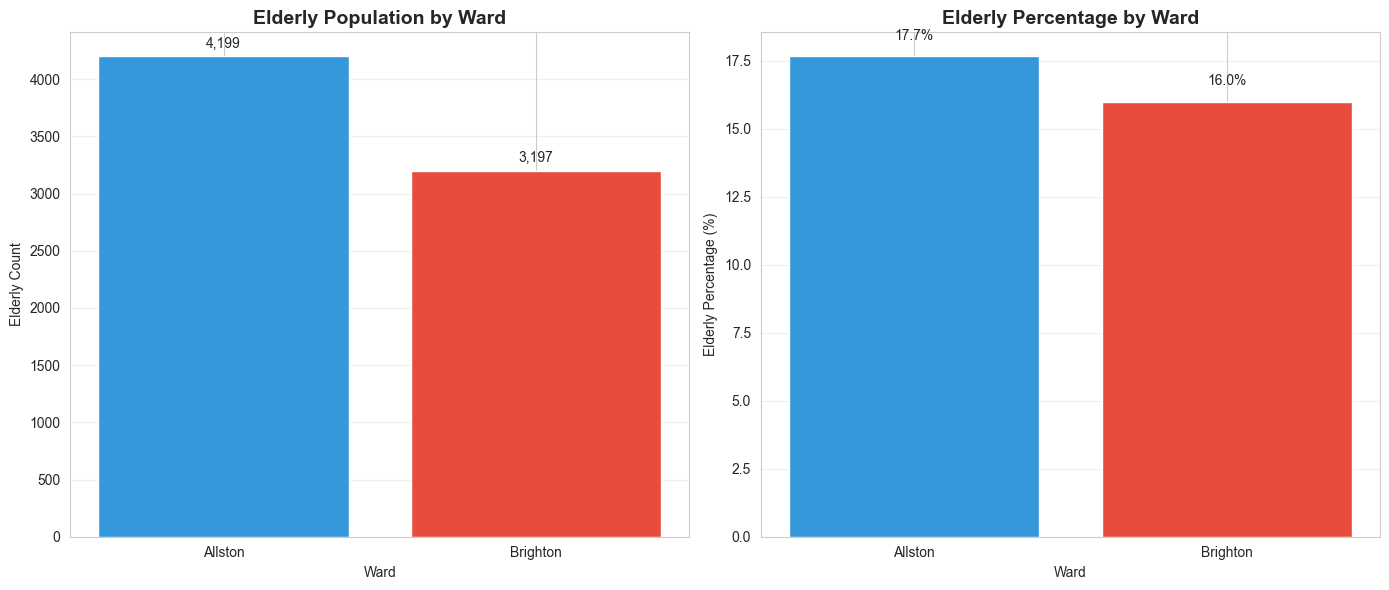

In [ ]:
query = """
SELECT 
    v.ward_id,
    COUNT(v.res_id) FILTER (WHERE v.is_elderly = true) as elderly_count,
    COUNT(v.res_id) as total_voters,
    ROUND(COUNT(v.res_id) FILTER (WHERE v.is_elderly = true) * 100.0 / COUNT(v.res_id), 2) as elderly_percentage,
    AVG(v.age) FILTER (WHERE v.is_elderly = true) as avg_age
FROM voters v
WHERE v.ward_id IS NOT NULL
GROUP BY v.ward_id
ORDER BY v.ward_id
"""

df_ward = pd.DataFrame(execute_query(query, fetch_all=True))

ward_name_map = {21: 'Allston', 22: 'Brighton'}
df_ward['ward_name'] = df_ward['ward_id'].map(ward_name_map).fillna('Ward ' + df_ward['ward_id'].astype(str))

df_ward['elderly_percentage'] = df_ward['elderly_percentage'].astype(float)
df_ward['avg_age'] = df_ward['avg_age'].astype(float)

print(df_ward.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.bar(df_ward['ward_name'], df_ward['elderly_count'], color=['#3498db', '#e74c3c'])
ax1.set_title('Elderly Population by Ward', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ward')
ax1.set_ylabel('Elderly Count')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(df_ward['elderly_count']):
    ax1.text(i, v + 50, f'{int(v):,}', ha='center', va='bottom')

ax2.bar(df_ward['ward_name'], df_ward['elderly_percentage'], color=['#3498db', '#e74c3c'])
ax2.set_title('Elderly Percentage by Ward', fontsize=14, fontweight='bold')
ax2.set_xlabel('Ward')
ax2.set_ylabel('Elderly Percentage (%)')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(df_ward['elderly_percentage']):
    ax2.text(i, float(v) + 0.5, f'{float(v):.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../reports/figures/elderly_ward_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### 2.2 Precinct Level Analysis


Top 10 Precincts by Elderly Count:
ward_precinct precinct_name  elderly_count elderly_percentage             avg_age
        21-13   Precinct 13            841              39.74 79.5172413793103448
        21-16   Precinct 16            540              33.23 77.7037037037037037
        21-12   Precinct 12            499              31.97 78.1503006012024048
         22-2    Precinct 2            423              17.18 73.3049645390070922
        21-10   Precinct 10            413              26.34 75.8934624697336562
         21-9    Precinct 9            352              14.59 73.9261363636363636
         22-8    Precinct 8            306              25.02 75.2287581699346405
         21-7    Precinct 7            281              18.32 72.5516014234875445
        22-12   Precinct 12            264              18.94 71.9810606060606061
         22-4    Precinct 4            257              18.70 73.4007782101167315


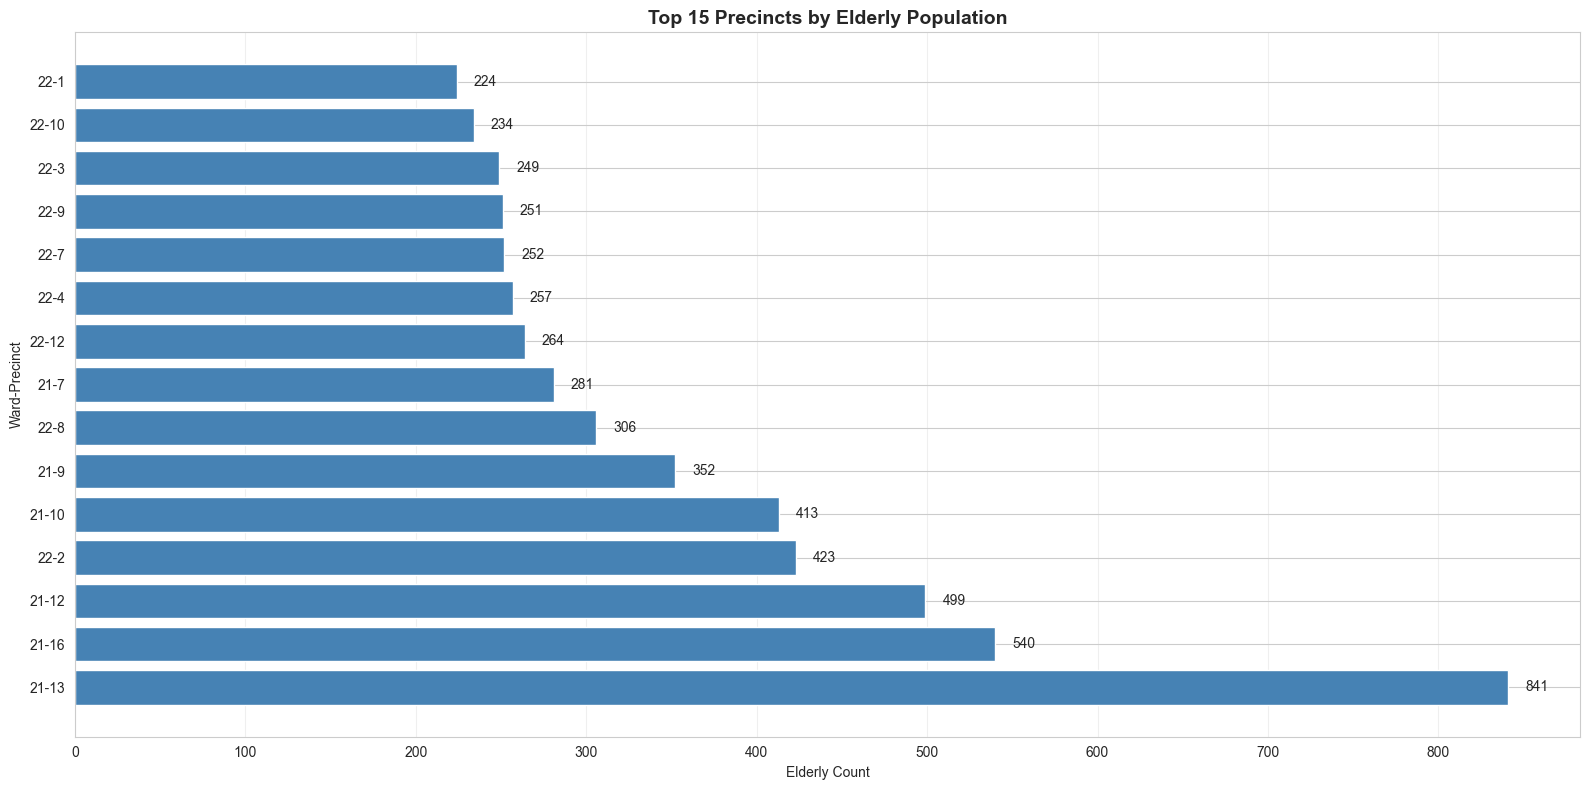

In [4]:
query = """
SELECT 
    p.ward_id,
    p.precinct_id,
    p.precinct_name,
    COUNT(v.res_id) FILTER (WHERE v.is_elderly = true) as elderly_count,
    COUNT(v.res_id) as total_voters,
    ROUND(COUNT(v.res_id) FILTER (WHERE v.is_elderly = true) * 100.0 / COUNT(v.res_id), 2) as elderly_percentage,
    AVG(v.age) FILTER (WHERE v.is_elderly = true) as avg_age
FROM precincts p
LEFT JOIN voters v ON p.precinct_id = v.precinct_id AND p.ward_id = v.ward_id
GROUP BY p.ward_id, p.precinct_id, p.precinct_name
ORDER BY p.ward_id, p.precinct_id
"""

df_precinct = pd.DataFrame(execute_query(query, fetch_all=True))
df_precinct['ward_precinct'] = df_precinct['ward_id'].astype(str) + '-' + df_precinct['precinct_id'].astype(str)

print(f"Top 10 Precincts by Elderly Count:")
print(df_precinct.nlargest(10, 'elderly_count')[['ward_precinct', 'precinct_name', 'elderly_count', 'elderly_percentage', 'avg_age']].to_string(index=False))

fig, ax = plt.subplots(figsize=(16, 8))
top_precincts = df_precinct.nlargest(15, 'elderly_count')
ax.barh(top_precincts['ward_precinct'], top_precincts['elderly_count'], color='steelblue')
ax.set_title('Top 15 Precincts by Elderly Population', fontsize=14, fontweight='bold')
ax.set_xlabel('Elderly Count')
ax.set_ylabel('Ward-Precinct')
ax.grid(axis='x', alpha=0.3)
for i, v in enumerate(top_precincts['elderly_count']):
    ax.text(v + 10, i, f'{int(v):,}', va='center')

plt.tight_layout()
plt.savefig('../reports/figures/elderly_precinct_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### 2.3 Street Level Analysis


Top 20 Streets by Elderly Count:
      street_name  ward_id  elderly_count elderly_percentage             avg_age
 COMMONWEALTH AVE       21            650              13.80 73.9384615384615385
   WALLINGFORD RD       21            548              77.73 83.0036496350364964
    WASHINGTON ST       21            513              41.24 78.7173489278752437
CHESTNUT HILL AVE       21            279              44.64 76.9534050179211470
      FIDELIS WAY       21            134              41.23 74.9029850746268657
        BEACON ST       21            118              20.56 75.5847457627118644
         COREY RD       21            115              34.53 79.2000000000000000
       ANTWERP ST       22            111              31.53 73.1891891891891892
       FANEUIL ST       22            104              19.37 70.5288461538461538
       EVERETT ST       22             83              35.47 79.5662650602409639
    GLENVILLE AVE       21             81              17.72 71.629629629629

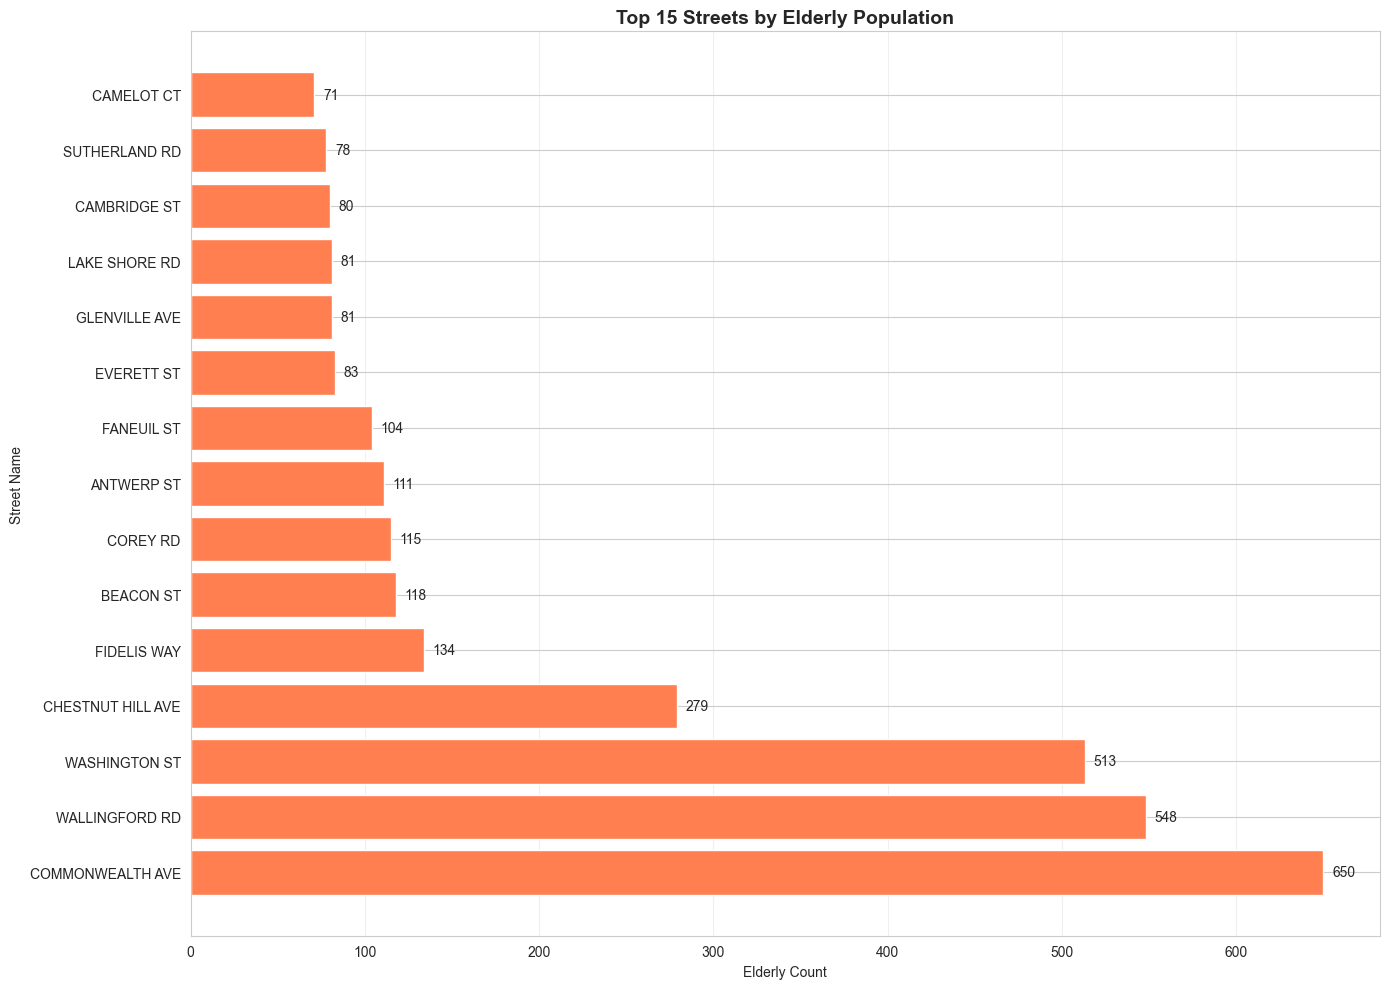

In [5]:
query = """
SELECT 
    v.street_name,
    v.ward_id,
    COUNT(v.res_id) FILTER (WHERE v.is_elderly = true) as elderly_count,
    COUNT(v.res_id) as total_voters,
    ROUND(COUNT(v.res_id) FILTER (WHERE v.is_elderly = true) * 100.0 / COUNT(v.res_id), 2) as elderly_percentage,
    AVG(v.age) FILTER (WHERE v.is_elderly = true) as avg_age
FROM voters v
WHERE v.street_name IS NOT NULL AND v.street_name != ''
GROUP BY v.street_name, v.ward_id
HAVING COUNT(v.res_id) FILTER (WHERE v.is_elderly = true) > 0
ORDER BY elderly_count DESC
LIMIT 20
"""

df_street = pd.DataFrame(execute_query(query, fetch_all=True))

print(f"Top 20 Streets by Elderly Count:")
print(df_street[['street_name', 'ward_id', 'elderly_count', 'elderly_percentage', 'avg_age']].to_string(index=False))

fig, ax = plt.subplots(figsize=(14, 10))
top_streets = df_street.head(15)
ax.barh(top_streets['street_name'], top_streets['elderly_count'], color='coral')
ax.set_title('Top 15 Streets by Elderly Population', fontsize=14, fontweight='bold')
ax.set_xlabel('Elderly Count')
ax.set_ylabel('Street Name')
ax.grid(axis='x', alpha=0.3)
for i, v in enumerate(top_streets['elderly_count']):
    ax.text(v + 5, i, f'{int(v):,}', va='center')

plt.tight_layout()
plt.savefig('../reports/figures/elderly_street_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Mapped Elders Analysis

Elders who are mapped to buildings


MAPPED ELDERS STATISTICS
Total elderly residents: 7,396
Mapped to buildings: 5,391 (72.9%)
Geocoded (has lat/long): 7,371 (99.7%)
Mapped AND geocoded: 5,388 (72.9%)


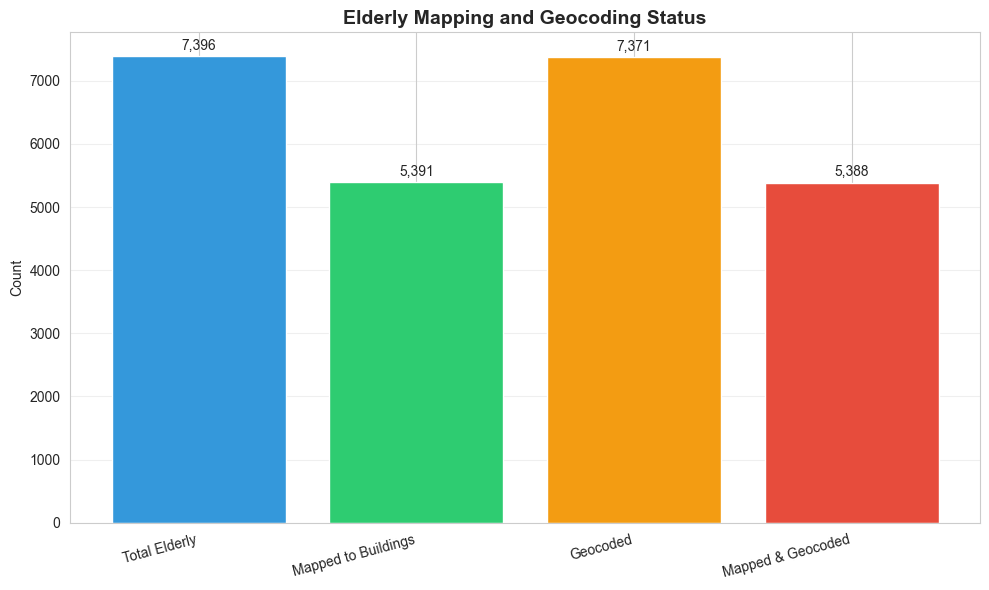

In [6]:
query = """
SELECT 
    COUNT(DISTINCT v.res_id) FILTER (WHERE v.is_elderly = true) as total_elderly,
    COUNT(DISTINCT v.res_id) FILTER (WHERE v.is_elderly = true AND vbm.res_id IS NOT NULL) as mapped_elderly,
    COUNT(DISTINCT v.res_id) FILTER (WHERE v.is_elderly = true AND v.latitude IS NOT NULL AND v.longitude IS NOT NULL) as geocoded_elderly,
    COUNT(DISTINCT v.res_id) FILTER (WHERE v.is_elderly = true AND vbm.res_id IS NOT NULL AND v.latitude IS NOT NULL AND v.longitude IS NOT NULL) as mapped_and_geocoded
FROM voters v
LEFT JOIN voters_buildings_map vbm ON v.res_id = vbm.res_id
WHERE v.is_elderly = true
"""

result = execute_query(query, fetch_one=True)

print("MAPPED ELDERS STATISTICS")
print("=" * 50)
print(f"Total elderly residents: {result['total_elderly']:,}")
print(f"Mapped to buildings: {result['mapped_elderly']:,} ({result['mapped_elderly']/result['total_elderly']*100:.1f}%)")
print(f"Geocoded (has lat/long): {result['geocoded_elderly']:,} ({result['geocoded_elderly']/result['total_elderly']*100:.1f}%)")
print(f"Mapped AND geocoded: {result['mapped_and_geocoded']:,} ({result['mapped_and_geocoded']/result['total_elderly']*100:.1f}%)")

fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Total Elderly', 'Mapped to Buildings', 'Geocoded', 'Mapped & Geocoded']
counts = [
    result['total_elderly'],
    result['mapped_elderly'],
    result['geocoded_elderly'],
    result['mapped_and_geocoded']
]
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(categories, counts, color=colors)
ax.set_title('Elderly Mapping and Geocoding Status', fontsize=14, fontweight='bold')
ax.set_ylabel('Count')
ax.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{int(count):,}', ha='center', va='bottom')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/elderly_mapping_status.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Census Tract Analysis with Map Visualization

Mapping elderly residents to census tracts using their building/parcel locations and showing both elderly count and median income per tract.


In [7]:
query = """
SELECT 
    ct.tract_id,
    ct.tract_name,
    ct.median_income,
    COUNT(DISTINCT v.res_id) as elderly_count,
    AVG(v.age) as avg_age
FROM voters v
INNER JOIN voters_buildings_map vbm ON v.res_id = vbm.res_id
INNER JOIN census_tracts ct ON ST_Within(
    ST_SetSRID(ST_MakePoint(v.longitude, v.latitude), 4326),
    ct.geometry
)
WHERE v.is_elderly = true
    AND v.latitude IS NOT NULL 
    AND v.longitude IS NOT NULL
    AND ct.geometry IS NOT NULL
GROUP BY ct.tract_id, ct.tract_name, ct.median_income
ORDER BY elderly_count DESC
"""

df_tract = pd.DataFrame(execute_query(query, fetch_all=True))
print(f"Census Tracts with Mapped Elderly Residents:")
print(df_tract.to_string(index=False))

print(f"\nSummary Statistics:")
print(f"Total tracts with elderly: {len(df_tract)}")
print(f"Total elderly mapped: {df_tract['elderly_count'].sum():,}")
print(f"Average elderly per tract: {df_tract['elderly_count'].mean():.1f}")
print(f"Median income range: ${df_tract['median_income'].min():,.0f} - ${df_tract['median_income'].max():,.0f}")


Census Tracts with Mapped Elderly Residents:
   tract_id                                         tract_name median_income  elderly_count             avg_age
25025000505   Census Tract 5.05; Suffolk County; Massachusetts      80556.00            965 78.5673289183222958
25025000701   Census Tract 7.01; Suffolk County; Massachusetts      93326.00            350 77.8228882833787466
25025000402   Census Tract 4.02; Suffolk County; Massachusetts     111705.00            344 72.9455337690631808
25025000401   Census Tract 4.01; Suffolk County; Massachusetts      75366.00            335 71.9849246231155779
25025000502   Census Tract 5.02; Suffolk County; Massachusetts      82125.00            330 73.3465346534653465
25025000503   Census Tract 5.03; Suffolk County; Massachusetts      92560.00            273 74.7430730478589421
25025000301   Census Tract 3.01; Suffolk County; Massachusetts     131206.00            265 73.3767123287671233
25025000506   Census Tract 5.06; Suffolk County; Massachuse

In [8]:
query = """
SELECT 
    ct.tract_id,
    ct.tract_name,
    ct.median_income,
    ST_AsGeoJSON(ct.geometry) as geometry_json,
    COUNT(DISTINCT v.res_id) as elderly_count
FROM voters v
INNER JOIN voters_buildings_map vbm ON v.res_id = vbm.res_id
INNER JOIN census_tracts ct ON ST_Within(
    ST_SetSRID(ST_MakePoint(v.longitude, v.latitude), 4326),
    ct.geometry
)
WHERE v.is_elderly = true
    AND v.latitude IS NOT NULL 
    AND v.longitude IS NOT NULL
    AND ct.geometry IS NOT NULL
GROUP BY ct.tract_id, ct.tract_name, ct.median_income, ct.geometry
ORDER BY elderly_count DESC
"""

tract_data = execute_query(query, fetch_all=True)

import json

tracts_geojson = {
    "type": "FeatureCollection",
    "features": []
}

for row in tract_data:
    if row['geometry_json']:
        geom = json.loads(row['geometry_json'])
        feature = {
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "tract_id": row['tract_id'],
                "tract_name": row['tract_name'],
                "median_income": float(row['median_income']) if row['median_income'] else 0,
                "elderly_count": int(row['elderly_count'])
            }
        }
        tracts_geojson["features"].append(feature)

print(f"Prepared {len(tracts_geojson['features'])} census tract features for mapping")


Prepared 21 census tract features for mapping


In [9]:
query = """
SELECT DISTINCT ON (v.res_id)
    v.res_id,
    v.latitude,
    v.longitude,
    v.age,
    ct.tract_id,
    ct.median_income
FROM voters v
INNER JOIN voters_buildings_map vbm ON v.res_id = vbm.res_id
INNER JOIN census_tracts ct ON ST_Within(
    ST_SetSRID(ST_MakePoint(v.longitude, v.latitude), 4326),
    ct.geometry
)
WHERE v.is_elderly = true
    AND v.latitude IS NOT NULL 
    AND v.longitude IS NOT NULL
    AND ct.geometry IS NOT NULL
ORDER BY v.res_id
LIMIT 5000
"""

elderly_points = execute_query(query, fetch_all=True)
df_elderly_points = pd.DataFrame(elderly_points)

print(f"Retrieved {len(df_elderly_points):,} elderly resident locations")


Retrieved 5,000 elderly resident locations


In [ ]:
from IPython.display import display

if 'tracts_geojson' not in globals():
    print("Error: tracts_geojson not found. Please run cell 14 first to create the census tract GeoJSON data.")
    raise NameError("tracts_geojson is not defined. Run cell 14 first.")

all_lats = []
all_lons = []
for feature in tracts_geojson['features']:
    geom = feature['geometry']
    if geom['type'] == 'Polygon':
        coords = geom['coordinates'][0]
    elif geom['type'] == 'MultiPolygon':
        coords = geom['coordinates'][0][0]
    if coords:
        all_lats.extend([coord[1] for coord in coords])
        all_lons.extend([coord[0] for coord in coords])

center_lat = sum(all_lats) / len(all_lats) if all_lats else 42.35
center_lon = sum(all_lons) / len(all_lons) if all_lons else -71.14

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=13,
    tiles='CartoDB positron'
)

max_elderly = max([f['properties']['elderly_count'] for f in tracts_geojson['features']])
min_income = min([f['properties']['median_income'] for f in tracts_geojson['features']])
max_income = max([f['properties']['median_income'] for f in tracts_geojson['features']])

try:
    cmap_income = mcolors.colormaps['RdYlGn']
except (KeyError, AttributeError):
    try:
        cmap_income = mcolors.colormaps.get_cmap('RdYlGn')
    except:
        try:
            cmap_income = plt.get_cmap('RdYlGn')
        except:
            cmap_income = mcolors.colormaps.get_cmap('RdYlGn')

norm_income = mcolors.Normalize(vmin=min_income, vmax=max_income)

def get_color_by_income(income):
    if income == 0:
        return '#f0f0f0'
    rgba = cmap_income(norm_income(income))
    return mcolors.rgb2hex(rgba)

for feature in tracts_geojson['features']:
    props = feature['properties']
    color = get_color_by_income(props['median_income'])
    
    geom = feature['geometry']
    coords = []
    
    if geom['type'] == 'Polygon':
        coords = geom['coordinates'][0]
    elif geom['type'] == 'MultiPolygon':
        coords = geom['coordinates'][0][0]
    
    if coords:
        centroid_lat = sum(coord[1] for coord in coords) / len(coords)
        centroid_lon = sum(coord[0] for coord in coords) / len(coords)
        
        folium.Marker(
            location=[centroid_lat, centroid_lon],
            icon=folium.DivIcon(
                html=f"""
                <div style="
                    background-color: white;
                    border: 2px solid #333;
                    border-radius: 5px;
                    padding: 3px 6px;
                    font-size: 11px;
                    font-weight: bold;
                    text-align: center;
                    box-shadow: 2px 2px 4px rgba(0,0,0,0.3);
                ">
                    {props['elderly_count']}
                </div>
                """,
                icon_size=(60, 25),
                icon_anchor=(30, 12)
            )
        ).add_to(m)
    
    folium.GeoJson(
        feature,
        style_function=lambda x, c=color: {
            'fillColor': c,
            'color': '#333',
            'weight': 2,
            'fillOpacity': 0.7
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['tract_id', 'tract_name', 'elderly_count', 'median_income'],
            aliases=['Tract ID:', 'Tract Name:', 'Elderly Count:', 'Median Income ($):'],
            localize=True
        ),
        popup=folium.GeoJsonPopup(
            fields=['tract_id', 'tract_name', 'elderly_count'],
            aliases=['Tract ID:', 'Tract Name:', 'Elderly Count:'],
            localize=True
        )
    ).add_to(m)

from branca.colormap import LinearColormap

colormap = LinearColormap(
    colors=['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#f7fcb9', '#d9f0a3', '#addd8e', '#78c679', '#41ab5d', '#238443', '#006837'],
    vmin=min_income,
    vmax=max_income,
    caption='Median Income per Census Tract ($) - Red=Low, Green=High'
)
colormap.add_to(m)

m.save('../reports/figures/elderly_census_tract_map.html')
print("Map saved to ../reports/figures/elderly_census_tract_map.html")
print(f"Color represents: Median Income (${min_income:,.0f} to ${max_income:,.0f})")
print(f"  - Red = Low Income, Green = High Income")
print(f"Labels show: Elderly Count (0 to {max_elderly:,}) and Median Income")

display(m)


Map saved to ../reports/figures/elderly_census_tract_map.html
Color represents: Median Income ($33,229 to $151,466)
  - Red = Low Income, Green = High Income
Labels show: Elderly Count (0 to 965) and Median Income


## Summary

This analysis provides a comprehensive view of elderly residents in Allston-Brighton:

1. **Total Count**: Elderly resident count from the voter dataset
2. **Geographic Distribution**: Analysis at ward, precinct, and street levels
3. **Mapping Status**: How many elderly are mapped to buildings and geocoded
4. **Census Tract Analysis**: Spatial distribution showing elderly count and median income by census tract

All visualizations and data are saved to the reports/figures directory.
